<a href="https://colab.research.google.com/github/leehj2586/leehj/blob/main/ESAA_0909_%ED%95%B8%EC%A6%88%EC%98%A87%EC%9E%A5_%EC%95%99%EC%83%81%EB%B8%94%EA%B3%BC%EB%9E%9C%EB%8D%A4%ED%8F%AC%EB%A0%88%EC%8A%A4%ED%8A%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

핸즈온 7장 앙상블 학습과 랜덤 포레스트 p. 245- 271

In [2]:
import warnings
warnings.filterwarnings('ignore')

# import package
import numpy as np
import os

#5장에서 소개한 moons dataset 불러오기

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X,y = make_moons(n_samples=100, noise=0.15)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Chapter 7 앙상블 학습과 랜덤 포레스트1

## 7.1 투표 기반 분류기
- 각 분류기의 예측을 모아 가장 많이 선택된 클래스를 예측하는 것 -> 다수결 투표로 정해지는 분류기 => 직접 투표 분류기(hard voting)
- 모든 분류기가 클래스의 확률 예측 가능 (=predict_proba() 매서드 존재) -> 개별 분류기의 예측을 평균내어 확률이 가장 높은 클래스 예측 가능 => 간접투표(soft voting)
- 약한 학습기 많고 다양(높은 정확도) -> 앙상블 -> 강한 학습기
- 큰수의 법칙
*SVC는 기본값에서는 클래스 확률 제공 X -> probability = True 지정

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators =[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [6]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.85
RandomForestClassifier 1.0
SVC 0.95
VotingClassifier 0.95


## 7.2 배깅과 페이스팅
- 배깅: 훈련세트에서 중복을 허용하여 샘플링을 하는 방식
- 페이스팅: 중복 허용X 샘플링
=> 같은 훈련 샘플을 여러개의 예측기에 걸쳐 사용 가능(배깅만)
- 앙상블: 모든 예측기의 예측을 모아 새로운 샘플에 대한 예측 생성
- 수집함수
    - 분류: 통계적 최빈값(like직접투표분류기)
    - 회귀: 평균 계산

### 7.2.1 사이킷런의 배깅과 페이스팅 : BaggingClassifier
- n_jobs : 훈련과 예측에 사용할 CPU 코어 수 지정 (-1: 가용한 모든 코어 사용)



In [8]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators = 500,
    max_samples=50, bootstrap=True, n_jobs = -1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

### 7.2.2 oob 평가
예측기가 훈련되는 동안 oob 샘플을 사용하지 X -> 별도의 검증 세트를 사용하지 않고 oob 샘플을 사용해 평가 가능   
-> 앙상플의 평가: 각 예측기의 oob 평가를 평균

In [9]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators = 500,
    bootstrap=True, n_jobs = -1, oob_score=True)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.95

In [10]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

1.0

In [12]:
bag_clf.oob_decision_function_

array([[0.95027624, 0.04972376],
       [0.97237569, 0.02762431],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.86163522, 0.13836478],
       [0.14      , 0.86      ],
       [0.96      , 0.04      ],
       [0.02116402, 0.97883598],
       [0.21938776, 0.78061224],
       [1.        , 0.        ],
       [0.13580247, 0.86419753],
       [0.74860335, 0.25139665],
       [0.00529101, 0.99470899],
       [1.        , 0.        ],
       [0.72826087, 0.27173913],
       [1.        , 0.        ],
       [0.97142857, 0.02857143],
       [0.98709677, 0.01290323],
       [0.98888889, 0.01111111],
       [0.88829787, 0.11170213],
       [0.26470588, 0.73529412],
       [0.18562874, 0.81437126],
       [0.98969072, 0.01030928],
       [1.        , 0.        ],
       [0.64088398, 0.35911602],
       [0.00492611, 0.99507389],
       [0.01069519, 0.98930481],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.04891304, 0.95108696],
       [0.

## 7.3 랜덤 패치와 랜덤 서브스페이스
- 특성 샘플링
    - 랜덤 패치 방식: 훈련특성과 샘플을 모두 샘플링하는 것
    - 랜덤 서브스페이스 방식: 훈련샘플을 모두 사용하고 특성은 샘플링하는 것

### 7.4 랜덤 포레스트
: 일반적으로 배깅 방법을 적용한 결정 트리의 앙상블
- 트리의 노드를 분할할 때 전체 특성 중 최선의 특성을 찾는 대신 무작위로 선택한 특성 후보중에서 최적의 특성을 찾는 식으로 무작위성 더 주입

In [13]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators = 500, max_leaf_nodes = 16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [14]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features='auto', max_leaf_nodes = 16),
    n_estimators = 500, max_samples = 1.0, bootstrap=True, n_jobs=-1)

#### 7.4.1 엑스트라 트리
: 트리를 더욱 무작위하게 만들기 위해 최적 임곗값을 찾는 대신 후보 특성을 사용해 무작위로 분할한 다음 그중에서 최상의 분할을 선택
- 익스트림랜덤트리 앙상블 : 편향은 늘어나지만 분산을 낮춤

#### 7.4.2 특성 중요도
- 랜덤포레스트의 장점: 특성의 상대적 중요도 측정이 쉬움

In [15]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators = 500, n_jobs=-1)
rnd_clf.fit(iris['data'], iris['target'])
for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11083226815913355
sepal width (cm) 0.024045207340173794
petal length (cm) 0.42868269397510955
petal width (cm) 0.43643983052558305


### 7.5 부스팅
: 약한 학습기를 여러개 연결하여 강한 학습기를 만드는 앙상블 방법
- 앞의 모델을 보완해나면서 일련의 예측기를 학습시키는 것
    - 에이다부스트
    - 그레이디언트 부스팅

#### 7.5.1 에이다부스트
: 이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높이는 방식을 사용


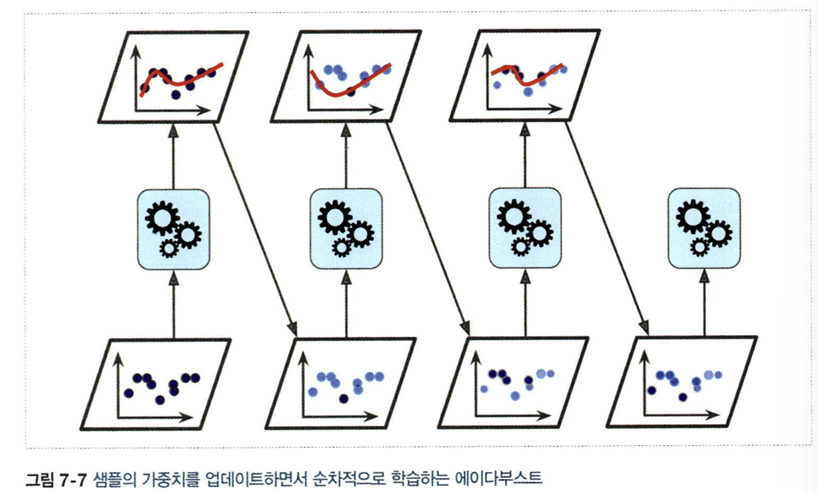

In [18]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm='SAMME.R', learning_rate=0.5)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

#### 7.5.2 그레디언트 부스팅
: 이전까지의 오차를 보정하도록 이전 예측기가 만든 잔여오차에 새로운 예측기 학습
- learning_rate: 각 트리의 기여 정도 조절
    - 0.1처럼 낮게 설정 -> 훈련세트에 학습시키기 위해 많은 트리 필요 but 일반적으로 예측 성능은 좋아짐 => 축소
- 조기종료
- warm_start=True : fit 매서드 호출시 기존 트리 유지, 훈련 추가

- 확률적 그레디언트 부스팅
    - subsample 매개변수 지원 : 각 트리 훈련 시 사용할 훈련 샘플 비율 지정
    - 편향이 높아지는 대신 분산이 낮아지며, 훈련 속도 상당히 상승


In [25]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X,y)

DecisionTreeRegressor(max_depth=2)

In [26]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2)

In [27]:
y3 = y - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2)

In [29]:
#y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [31]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators = 3, learning_rate=1.0)
gbrt.fit(X,y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

In [33]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X,y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors)+1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators = bst_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=101)

In [34]:
gbrt = GradientBoostingRegressor(max_depth = 2, warm_start = True)

min_val_error = float('inf')
error_going_up = 0
for n_estimators in range(1,120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up ==5:
            break       # 조기종료

In [35]:
import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

In [ ]:
xgb_reg.fit(X_train, y_train,
            eval_set=[(X_val, y_val)],  early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)

### 7.6 스태킹
- 각 예측기로 예측 후, 마지막 예측기(블렌더)가 이 예측을 입력으로 받아 최종 예측 생성
- 블랜더 학습 방법
    - 홀드아웃세트 사용

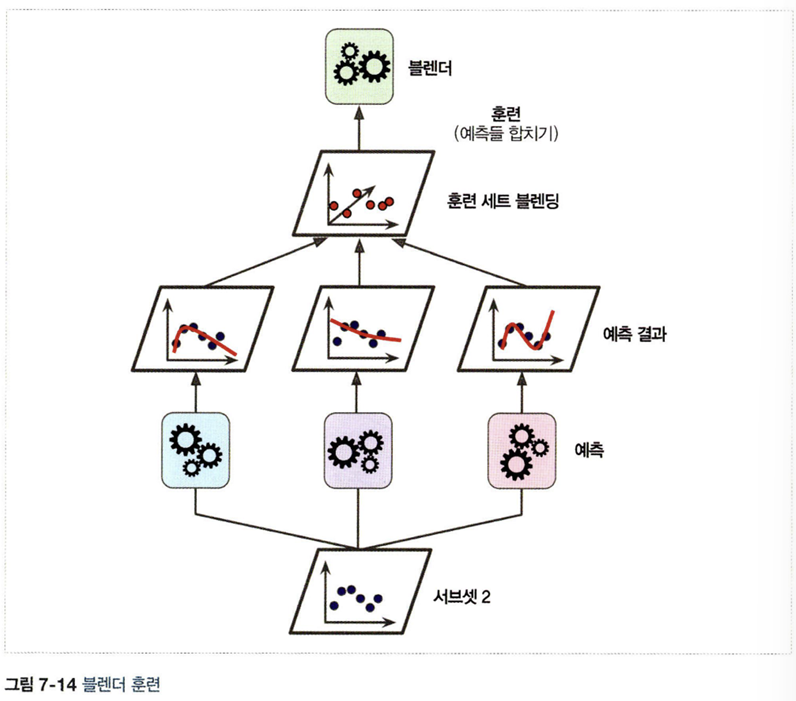